In [27]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt

Now that we have a clean dataset of factors the BTS believes affect flight delay, we can begin exploring and processing this data to ensure that it is in a model-friendly format and to remove any entries in it that could negatively affect the performance of our future flight delay model.

In order to accomplish this, we must accomplish three things. First, we must remove any parts of the dataset that are not relevant to our model's training. Second, we must carefully inspect the data for outliers that are not representative of typical aviation conditions. And thirdly, we must convert our trimmed and inspected dataset into the numeric format that our delay model will be expecting.

We will begin by bringing in our cleaned dataset.

In [28]:
# Reading in the cleaned dataset
delay_df = pd.read_pickle('./data/cleaned_aviation_data')

## Data Trimming

Within our dataset are several columns that shoould either be separated from our dataset or removed entirely to optimize the training of our future model. The first of these columns is `ArrDel15`. This column, as mentioned previously, contains the target variable of delay status that our model is aiming to predict. Since this column's data is the target and not a predictor, it should be separated out from the dataset so that it can be processed differently.

In [29]:
# Extracting target delay data column from the dataset
delayed = delay_df[['ArrDel15']]
delay_df = delay_df.drop("ArrDel15",axis=1)

Looking at the remainder of the columns, we can see two broader categories of columns that will need to be removed to ensure that the model is trained correctly.

Firstly, the model contains several columns that express the exact same data in different formats. As an example, there is a column for the unique ID number of an airport, as well as a column for the unique _name_ of an airport. From the perspective of our future model, these two columns contain identical data, since both contain collections of characters that uniquely identify a particular airport. Including redundant columns such as these has the potential to greatly worsen or slow down model training, as the model will attempt to train on these columns as if they were completely independent of one another. This makes it difficult for our model to identify the importance of each column to its predictions, while not actually adding any new information. As such, these redundant columns can only have detrimental effects on our model and all but one of each should be removed.

Secondly, we can see that many of the dataset's columns contain information that can only be collected after a flight has already been completed, such as the wheels-on time or actual air time of a flight. Since the purpose of this data and our model is to _premptively_ predict whether or not a flight will be delayed, we must make sure to restrict ourselves to only information that can be collected _before_ a flight has taken off. For this reason, we must make sure to remove any columns that contain such inapplicable information.

The following cell trims the dataset down to only the columns that conform to these requirements.

In [30]:
# Defining relevant columns and trimming the dataset down to relevant columns
relevant_columns = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Distance',
                    'Origin', 'OriginCityName', 'OriginStateName', 'OriginCityMarketID',
                    'Dest', 'DestCityName', 'DestStateName', 'DestCityMarketID',
                    'Reporting_Airline', 'ActualElapsedTime', 'AirTime']
delay_df = delay_df[relevant_columns]

## Exploratory Data Analysis

Now that our data has been cleaned of any missing or incompatible data points that would prevent us from training our flight delay model, we must investigate the data for any extreme outliers that could negatively bias its training.

To do so, we can look through the summary statistics for our dataset.

In [37]:
# Displaying relevant summary statistics for the flight delay dataset
delay_df.describe().drop('count')
# :Thinkos_Emoji: ah yes, 8 minute flight

,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,OriginCityMarketID,DestCityMarketID,ActualElapsedTime,AirTime
mean,2021.834980,2.529408,6.588636,15.764581,3.965241,816.832948,31746.469742,31747.379146,137.278407,112.758154
std,0.371199,1.104503,3.393561,8.762020,2.007495,596.564406,1316.364355,1316.859508,72.273017,70.220485
min,2021.000000,1.000000,1.000000,1.000000,1.000000,31.000000,30070.000000,30070.000000,14.000000,8.000000
25%,2022.000000,2.000000,4.000000,8.000000,2.000000,385.000000,30647.000000,30666.000000,84.000000,61.000000
50%,2022.000000,3.000000,7.000000,16.000000,4.000000,666.000000,31453.000000,31453.000000,121.000000,96.000000
75%,2022.000000,4.000000,10.000000,23.000000,6.000000,1051.000000,32467.000000,32467.000000,168.000000,142.000000
max,2022.000000,4.000000,12.000000,31.000000,7.000000,5095.000000,36101.000000,36101.000000,764.000000,727.000000


Looking here at these summary statistics, we can see several values that stick out as counterintuitive and potentially anomalous.

Most obviously, the `AirTime` column has minimum and maximum values of 8 minutes and 727 minutes respectively. Such extreme flight times stand out as being potentially incorrect or irregular values deserving of further inspection to determine if they represent a real and typical occurance that our model should train on or an extraordinary event that would simply mislead its training.

Less obviously, we can see that the average and median values for the `Quarter`, `Month`, `DayofMonth`, and `DayOfWeek` do not match. This suggests that there are more flights recorded on some times than on others. If this difference in flights is too large, it could affect our model's ability to predict flights on times with fewer recorded flights. As such, it is worth inspecting the distributions of these data columns as well.

And most subtly of all, we can see that the mean and 25th percentile values for `OriginCityMarketID` and `DestCityMarketID` are different. This raises the question of whether the distribution of origins for flights matches the distribution of destinations for flights. We would expect there to be a high resemblance between the two as most airports make an effort to maintain similar rates of incoming and outgoing flights to keep routes stable.

We can begin by inspecting the flights with the lowest and highest air time.

In [38]:
# Inspecting the flights with the lowest air time
delay_df.sort_values('AirTime').head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,Origin,OriginCityName,OriginStateName,OriginCityMarketID,Dest,DestCityName,DestStateName,DestCityMarketID,Reporting_Airline,ActualElapsedTime,AirTime
521772,2022,2,4,25,1,31.0,WRG,"Wrangell, AK",Alaska,35841,PSG,"Petersburg, AK",Alaska,34256,AS,16.0,8.0
454238,2022,4,10,11,2,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,33.0,8.0
276126,2021,4,11,5,5,31.0,WRG,"Wrangell, AK",Alaska,35841,PSG,"Petersburg, AK",Alaska,34256,AS,20.0,8.0
449115,2022,4,10,3,1,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,23.0,8.0
536041,2022,2,5,15,7,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,21.0,8.0
512846,2022,3,9,7,3,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,31.0,8.0
251912,2022,3,8,27,6,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,22.0,8.0
415218,2021,4,11,11,4,31.0,WRG,"Wrangell, AK",Alaska,35841,PSG,"Petersburg, AK",Alaska,34256,AS,15.0,8.0
547111,2022,2,6,30,4,31.0,PSG,"Petersburg, AK",Alaska,34256,WRG,"Wrangell, AK",Alaska,35841,AS,24.0,8.0
450448,2022,4,10,5,3,31.0,WRG,"Wrangell, AK",Alaska,35841,PSG,"Petersburg, AK",Alaska,34256,AS,18.0,8.0


Looking at the above data, we can find evidence that the seemingly anomalous 8 minute air time flights are completely typical data points. The vast majority of 8 minute flights are between two Alaskan cities with only 31 miles between them. Seeing as how most commercial aircraft reach speeds of up to 550 mph, an 8 minute travel time between these two locations is completely reasonable. As such, this data is _not_ anomalous and should be kept in our dataset.

In [39]:
# Inspecting the flights with the highest air time
delay_df.sort_values('AirTime', ascending=False).head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,Distance,Origin,OriginCityName,OriginStateName,OriginCityMarketID,Dest,DestCityName,DestStateName,DestCityMarketID,Reporting_Airline,ActualElapsedTime,AirTime
210984,2022,1,1,1,6,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,764.0,727.0
222457,2021,4,12,5,7,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,736.0,711.0
222456,2021,4,12,4,6,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,720.0,687.0
222463,2021,4,12,13,1,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,719.0,687.0
221903,2021,4,12,5,7,4983.0,JFK,"New York, NY",New York,31703,HNL,"Honolulu, HI",Hawaii,32134,HA,733.0,686.0
279200,2021,4,11,17,3,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,701.0,678.0
230035,2022,1,3,2,3,4983.0,JFK,"New York, NY",New York,31703,HNL,"Honolulu, HI",Hawaii,32134,HA,705.0,675.0
221360,2022,2,4,15,5,4757.0,MCO,"Orlando, FL",Florida,31454,HNL,"Honolulu, HI",Hawaii,32134,HA,698.0,673.0
278703,2021,4,11,17,3,4983.0,JFK,"New York, NY",New York,31703,HNL,"Honolulu, HI",Hawaii,32134,HA,703.0,673.0
279194,2021,4,11,8,1,5095.0,BOS,"Boston, MA",Massachusetts,30721,HNL,"Honolulu, HI",Hawaii,32134,HA,694.0,672.0


Similarly, we can see evidence above that the extremely high 727 minute air time flights are also completely typical data points. These high air-time entries are for flights from the east coast of the U.S. to Honolulu in Hawaii. Given that these locations have upwards of 5000 miles between them, 10+ hour travel times are completely reasonable. Seeing the prevalence of these flights in our dataset, we can once again conclude that these high air time entries are not anomalous and should be kept in our dataset.

With the unexpected air times thus addressed, we can move on to inspecting the distribution of flights across time periods.

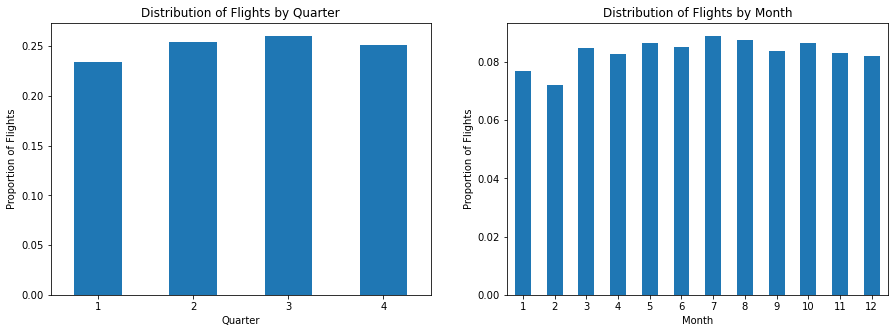

In [70]:
# Displaying the proportion of flights by quarter and by month
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
delay_df.Quarter.value_counts(normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0],
                                                                xlabel='Quarter', ylabel='Proportion of Flights',
                                                                title='Distribution of Flights by Quarter');
delay_df.Month.value_counts(normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1],
                                                                xlabel='Month', ylabel='Proportion of Flights',
                                                                title='Distribution of Flights by Month');

In the above plots, we can see that there is very little difference in the number of flights between most months. The noteworthy exceptions to this are January and February, which had noticeably less flight traffic than the others and subsequently led to quarter 1 having a lower proportion of flights as well. Given the fact that these months come immediately after the major holiday season, this is not unexpected.

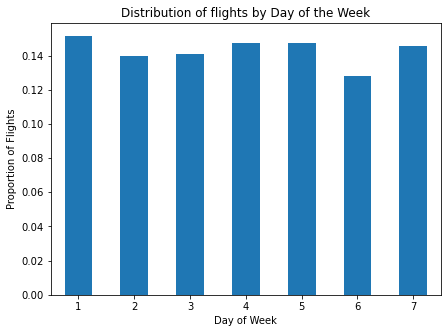

In [75]:
# Displaying the proportion of flights by day of the week
plt.figure(figsize=(7,5))
delay_df.DayOfWeek.value_counts(normalize=True).sort_index().plot(kind='bar', rot=0,
                                                                  xlabel='Day of Week', ylabel='Proportion of Flights',
                                                                  title='Distribution of flights by Day of the Week');

Looking at the days of the week, we similarly see that there is very little difference in flight traffic across the majority of them, with the noticable exception of Friday, which sees fewer flights than any other day.

As there are no egregious differences in the amount of data available for each time period, we do not need to worry about the model being unable to learn how to predict flights that occur at specific times.

We can now move on to inspecting the distributions of the remaining columns through the following histograms.

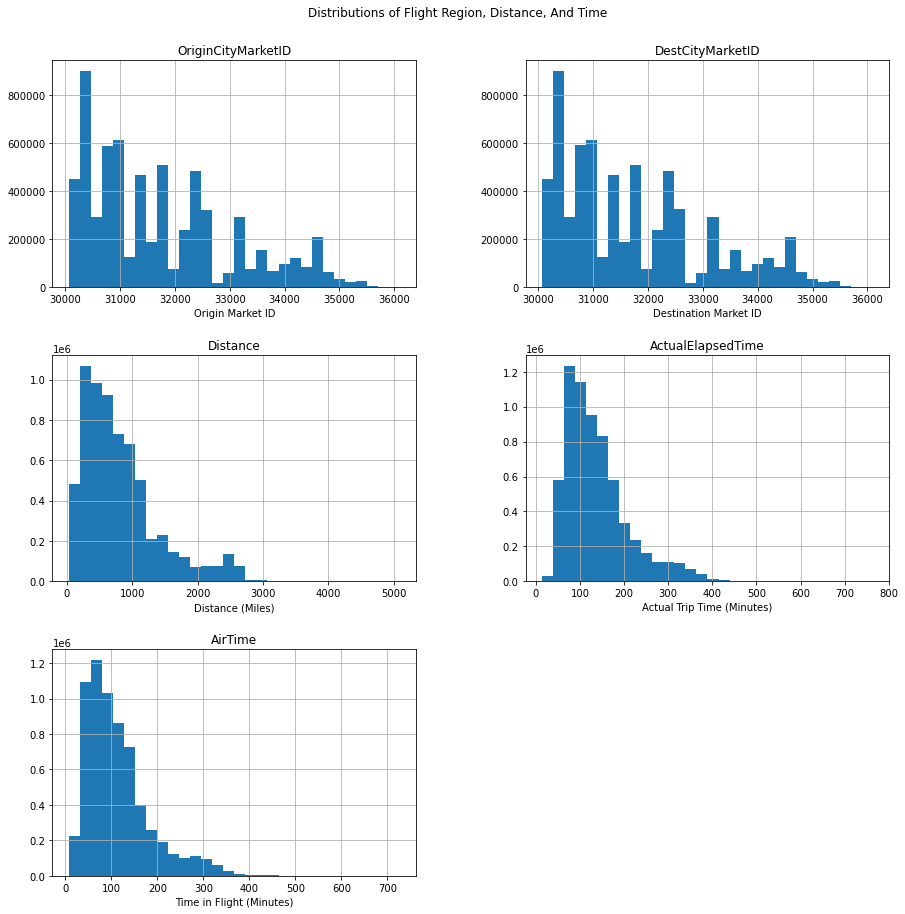

In [109]:
# Visualizing the distributions of key numeric data columns
# delay_df.drop(['Year', 'Quarter', 'Month', 'DayOfWeek'], axis=1).hist(figsize=(15,15), layout=(3,2), bins=31);
columns_to_plot = ['OriginCityMarketID', 'DestCityMarketID', 'Distance', 'ActualElapsedTime', 'AirTime']
plts = delay_df.loc[:,columns_to_plot].hist(figsize=(15,15), layout=(3,2), bins=30);
plt.suptitle('Distributions of Flight Region, Distance, And Time', y=0.93);
plts[0][0].set_xlabel("Origin Market ID");
plts[0][1].set_xlabel("Destination Market ID");
plts[1][0].set_xlabel("Distance (Miles)");
plts[1][1].set_xlabel("Actual Trip Time (Minutes)");
plts[2][0].set_xlabel("Time in Flight (Minutes)");

In the above distributions of data, we can make two key observations that confirm our expectations for our dataset.

Firstly, we can see that the distributions of airport market region IDs are nearly identical, as expected. While our summary statistics indicated that they were not identical, a broader look at the data as a whole confirms our expectation that they are _nearly_ identical. As such, there is no anomaly in the distributions of those two columns.

In addition to this, we can see that the distributions of trip distance, actual trip time, and time in the air are all very similar as well. This is exactly as we would expect, since the vast majority of most trips' time is spent in flight and the time spent in flight is directly related to the distance that a flight must cover. Therefore, there is no anomaly in these three columns sharing a nearly identical left-skewed distribution.

Now that we have finished trimming and inspecting our dataset, we can be confident that all the data it contains is relevant to the flight delay model we wish to train. All that remains is to convert it into the proper format.

## Pre-Processing

In order to ensure that our dataset is in a format that our delay model will be able to understand and train on, it is important that we pre-process our data into a format that is model-friendly. While strings of text and columns of data with explicit units are helpful for any humans attempting to understand our dataset, they are not the best way to present information to a machine learning model. In order to prepare our dataset for use in modelling, we will need to perform one last set of alterations.

To begin, we must correct an issue with the way that our dataset currently represents airport market IDs. Currently, market IDs are being represented as a number rather then as a string of characters. While this is useful for human interpretation and exploration of the data, it conveys the wrong message to model. When pure numeric data is given to a model, it is nearly always interpreted as a continuous value that affects the target delay variable when it changes. This is _not_ what our market IDs are.

Rather than being a continuous predictive value, our market IDs are discrete values meant to uniquely identify regions in the United States. In order to convey this notion of the IDs as unique identifiers to our model, we can change our dataset's internal representation of the IDs from numbers to characters of text. This change, combined with subsequent pre-processing steps, will ensure that our model views these IDs as identifiers and not as a continuous variable.

This conversion is accomplished in the following cell.

In [8]:
# Converting ID numbers to categorical string data
delay_df.OriginCityMarketID = delay_df.OriginCityMarketID.astype(str)
delay_df.DestCityMarketID = delay_df.DestCityMarketID.astype(str)

Before continuing with our pre-processing, we must take our dataset and split it into training and testing data.

In order to determine the effectiveness of our model on new data it hasn't seen before, we must separate off a piece of our dataset _before_ our modelling pipeline so that we can use it to evaluate our models after they are made.

In [9]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(delay_df, delayed, stratify=delayed)

Now that our data has been throughly typecast and segmented, we can address the two major expectations of our flight delay model.

    * All data must be provided in numeric format
    * All data should be on the same scale

All the data in our dataset falls into one of two groups: categorical or numeric. Categorical features have entries that are represented by text rather than by numeric values. However, machine learning models cannot understand text data in its raw format. In order to ensure that all the inputs to our flight delay model are usable by our model, we need to convert our categorical features from text into quantitative values. 

Similarly, our models will struggle to properly train on numeric data that is significantly larger or smaller in scale than other data. In order to prevent models from overfitting to a dataset and simply memorizing it instead of learning the underlying patterns, it is common to penalize models that place too much weight on specific data columns. However, This process of penalizing large weights also inadvertantly skews the importance of columns with values that differ in magnitude, such as flight distance and month. In order to ensure that all of our numeric features are on the same scale, we must alter our features by subtracting their mean and dividing by their standard deviation.

In order to scale numeric features a StandardScaler transformer can be used, in order to convert our categorical features a OneHotEncoder can be used.

First we start off by identifying our numeric and categorical columns.

In [10]:
# Recording which columns are numeric and which are categorical
numeric_cols = X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')].index.tolist()
non_numeric_cols = X_train.dtypes[(X_train.dtypes != 'int64') & (X_train.dtypes != 'float64')].index.tolist()

Now that we have selected our columns, we can create and apply our StandardScaler and OneHotEncoder to our dataset.

In [11]:
# Creating a transformer object to scale numeric data and encode categorical data
encoder = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols),
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), non_numeric_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [12]:
# Applying pre-processing transformations
encoder.fit(X_train)
X_train_sparse = encoder.transform(X_train)
X_train_columns = encoder.get_feature_names_out()
X_test_sparse = encoder.transform(X_test)
X_test_columns = encoder.get_feature_names_out()

## Saving the Data

With this, our dataset has been fully encoded into a model friendly format and packaged into a space efficient format known as a sparse matrix. In exchange for not being able to perform visualizing operations or contain labelled columns, this sparse matrix will exponentially reduce the amount of memory requred to store or load a dataset with many `0`'s in it.

Due to the sheer size of our newly processed dataset, it is easier and faster to store our dataset in this newly generated format and package its column names separately than it is to represent it as a typical table of data.

With our data thus pre-processed it is finally ready to be saved and used for the creation of our BTS flight delay model.

In [13]:
# Storing fully transformed data
y_train.to_pickle('./data/y_train')
y_test.to_pickle('./data/y_test')
with open('./data/X_train_sparse.pickle', 'wb') as new_pickle:
    pickle.dump(X_train_sparse, new_pickle, pickle.HIGHEST_PROTOCOL)
with open('./data/X_test_sparse.pickle', 'wb') as new_pickle:
    pickle.dump(X_test_sparse, new_pickle, pickle.HIGHEST_PROTOCOL)
with open('./data/X_train_columns.pickle', 'wb') as new_pickle:
    pickle.dump(X_train_columns, new_pickle, pickle.HIGHEST_PROTOCOL)
with open('./data/X_test_columns.pickle', 'wb') as new_pickle:
    pickle.dump(X_test_columns, new_pickle, pickle.HIGHEST_PROTOCOL)